In [1]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import torch_pruning as tp
from mobilenetv3 import mobilenetv3
from collections import defaultdict
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import pytorch_lightning as L
import h5py
from torch.utils.data import Dataset
import copy
import torch.nn as nn 
from tqdm import tqdm
from torchinfo import summary
import csv
from torch.profiler import profile

In [22]:
# Free up cached memory
torch.cuda.empty_cache()

# Clear all the gradients
torch.cuda.reset_max_memory_allocated()

/home/mohammad.hallaq/workarea/venv/lib/python3.10/site-packages/torch/cuda/memory.py:330: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [2]:
class RFClassifier(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.lr = 3e-4
        self.lr_ignored = 3e-4  # Learning rate for ignored layers

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        # Initialize lists for different parameter groups
        ignored_layers_params = []
        other_layers_params = []

        # Collect parameters of specific layers based on layer names and conditions
        ignored_params_set = set()
        for name, m in self.model.named_modules():
            if any(name.startswith(f'blocks.{i}') for i in range(3)) or (isinstance(m, torch.nn.Linear) and m.out_features == 2):
                ignored_layers_params += list(m.parameters())
                ignored_params_set.update(m.parameters())  # Add to set to avoid duplicates

        # Other parameters: Exclude the ignored layers' parameters
        other_layers_params = [p for p in self.model.parameters() if p not in ignored_params_set]

        # Create the optimizer with different learning rates for different parameter groups
        optimizer = torch.optim.AdamW([
            {'params': ignored_layers_params, 'lr': self.lr_ignored},  # Lower learning rate for ignored layers
            {'params': other_layers_params, 'lr': self.lr}  # Default learning rate for other layers
        ], weight_decay=0)

        # Learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1)

        return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': lr_scheduler, 'interval': 'step'}}

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss, prog_bar=True)

In [3]:
class CustomCheckpoint(L.Callback):
    def __init__(self):
        super().__init__()
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_validation_end(self, trainer, pl_module):
        # Access validation loss from the trainer's metrics
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = pl_module.model
            # Save the best model
            torch.save(self.best_model, 'best_model.pth')
            print(f"New best model saved with validation loss {val_loss:.4f}")


In [4]:
class R22_H5_Dataset(Dataset):
    def __init__(self, data_file, label='label', iqlabel='iq_data'):
        self.data_file = data_file
        self.label = label
        self.iqlabel = iqlabel

    def __len__(self):
        with h5py.File(self.data_file, 'r') as f:
            length = len(f[self.label])
        return length

    def __getitem__(self, idx):
        with h5py.File(self.data_file, 'r') as f:
            iq_data = f[self.iqlabel][idx]
            label = f[self.label][idx]
        return iq_data, label
    
    def get_metadata(self, idx):
        with h5py.File(self.data_file, 'r') as f:
            metadata = {
                'recording': f['recording'][idx].decode('utf-8)'),
                'category': f['category'][idx].decode('utf-8)')
            }
        return metadata


In [26]:
def prune_model(trained_model, prune_method, prune_amount, train_loader):

    # torch.manual_seed(80) 
    model =  copy.deepcopy(trained_model)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    example_length = 4096

    if prune_method == 'channel_pruning_Taylor_importance':
        imp = tp.importance.TaylorImportance() 

        ignored_layers_group1 = []

        for name, m in model.named_modules():
            # Check if the module is within Sequential(3), Sequential(4), Sequential(5) or the classifier
            if any(name.startswith(f'blocks.{i}') for i in range(3)) or (isinstance(m, torch.nn.Linear) and m.out_features == 2):
                ignored_layers_group1.append(m)

        ignored_layers_group2 = []
    
        for name, m in model.named_modules():
            # Check if the module is within Sequential(0), Sequential(1), Sequential(2) or the classifier
            if any(name.startswith(f'blocks.{i+3}') for i in range(3)) or (isinstance(m, torch.nn.Linear) and m.out_features == 2):
                ignored_layers_group2.append(m) 


        batch = next(iter(train_loader))
        x, y = batch
        x = x.to(device)
       
        iterative_steps= 1
        pruner_group1 = tp.pruner.MagnitudePruner( 
            model,
            example_inputs=x,
            importance=imp,
            pruning_ratio=prune_amount, 
            # pruning_ratio_dict = {model.conv1: 0.2, model.layer2: 0.8}, # customized pruning ratios for layers or blocks
            ignored_layers=ignored_layers_group1,
            iterative_steps= iterative_steps,
            global_pruning=True,
            # isomorphic=True
        )

        pruner_group2 = tp.pruner.MagnitudePruner( 
            model,
            example_inputs=x,
            importance=imp,
            pruning_ratio=0.7, 
            # pruning_ratio_dict = {model.conv1: 0.2, model.layer2: 0.8}, # customized pruning ratios for layers or blocks
            ignored_layers=ignored_layers_group2,
            iterative_steps= iterative_steps,
            global_pruning=True,
            # isomorphic=True
        )

        # prune the model, iteratively if necessary.
        for i in range(iterative_steps):

            # Taylor expansion requires gradients for importance estimation
            if isinstance(imp, tp.importance.TaylorImportance):
                
                x, y = batch
                x = x.to(device)
                y = y.to(device)
                y_hat = model(x)
                loss = F.mse_loss(y_hat, y)
                loss.backward()

            pruner_group1.step()
            pruner_group2.step()

    return model

In [5]:
original_model_checkpoint = 'august22_beam_t.ckpt'

In [6]:
train_data = '/home/mohammad.hallaq/workarea/MobileNet_compression/data_h5py_files/r22_train.h5'
val_data = '/home/mohammad.hallaq/workarea/MobileNet_compression/data_h5py_files/r22_val.h5'
test_data = '/home/mohammad.hallaq/workarea/MobileNet_compression/data_h5py_files/r22_test.h5'
checkpoint_dir = '/home/mohammad.hallaq/workarea/MobileNet_compression/checkpoints-Copy2'
checkpoint_filename = os.path.join(checkpoint_dir, 'august22_beam_t.ckpt')
checkpoint =torch.load(checkpoint_filename)

In [7]:
example_length = 4096
batch_size = 128
epochs =30

hparams = {
    'drop_path_rate': 0.2,
    'drop_rate': 0.7,
    'learning_rate': 3e-3,
    'wd': 0.01
}

In [30]:
def train_model_with_pruning(trained_model, pruning_method, model_name_suffix, train_loader, val_loader, prune_amount):
    checkpoint_filename = f"model_pruned_{model_name_suffix}_amount_{prune_amount}.ckpt"
    final_model_path = f'model_final_pruned_{model_name_suffix}_amount_{prune_amount}.pth'

   
    if os.path.exists(checkpoint_filename) or os.path.exists(final_model_path):
        print(f"Model {model_name_suffix} at {prune_amount * 100}% pruning already exists. Skipping training.")
        return

    pruned_model = prune_model(trained_model, pruning_method, prune_amount, train_loader)

    rf_classifier = RFClassifier(pruned_model)

    checkpoint_callback = L.callbacks.ModelCheckpoint(
        dirpath='.',
        filename=checkpoint_filename.replace(".ckpt", ""),
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )
    
    # Create the custom callback
    custom_checkpoint = CustomCheckpoint()

    trainer = L.Trainer(
        max_epochs=1,
        callbacks=[checkpoint_callback, custom_checkpoint],
        accelerator='gpu',
        devices=1,
        benchmark=True,
        precision='32-true',
    )

    print(f"Training the model with {pruning_method} applied at {prune_amount * 100}%...")
    trainer.fit(rf_classifier, train_loader, val_loader)

    torch.save(rf_classifier.model, final_model_path)

    print(f"Model {pruning_method} at {prune_amount * 100}% pruning saved. ")


In [31]:
# train_data = '/home/mohammad.hallaq/workarea/AoA-Pruning/data_h5py_files/r22_train.h5'
# val_data = '/home/mohammad.hallaq/workarea/AoA-Pruning/data_h5py_files/r22_test.h5'

In [32]:
# example_length = 4096
# batch_size = 128
# epochs =30

In [8]:
train_set = R22_H5_Dataset(train_data)
val_set = R22_H5_Dataset(val_data)
test_set = R22_H5_Dataset(test_data)
print(f'Training Set: {len(train_set)} examples')
print(f'Validation Set: {len(val_set)} examples')
print(f'Testing Set: {len(test_set)} examples')

num_classes = train_set[0][1].shape[0]

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    )
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=128,
    shuffle=False,
    num_workers=8
    )
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=128,
    shuffle=False,
    num_workers=8
    )

Training Set: 268515 examples
Validation Set: 29835 examples
Testing Set: 74685 examples


In [9]:
original_model = mobilenetv3(
    model_size='mobilenetv3_small_050',
    num_classes=num_classes,
    drop_rate=hparams['drop_rate'],
    drop_path_rate=hparams['drop_path_rate'],
    in_chans=8
)

# rf_classifier = RFClassifier.load_from_checkpoint(original_model_checkpoint, model=model)

# rf_classifier.to('cuda' if torch.cuda.is_available() else 'cpu')


In [10]:
def remove_prefix_from_state_dict(state_dict, prefix='model.'):

    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith(prefix):
            new_state_dict[k[len(prefix):]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

In [11]:
checkpoint['state_dict'] = remove_prefix_from_state_dict(checkpoint['state_dict'], prefix='model.')

original_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [12]:
pruning_methods = ['channel_pruning_Taylor_importance']
pruning_amounts = [0.95]  

In [33]:
pruned_model = prune_model(original_model, pruning_methods[0], pruning_amounts[0], train_loader)

In [14]:
pruned_model = torch.load('/home/mohammad.hallaq/workarea/MobileNet_compression/best_model(20011_parameters).pth')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pruned_model = pruned_model.to(device)

In [15]:
example_inputs = torch.randn(1, 8, 4096)
example_inputs = example_inputs.to('cuda')  
macs, nparams = tp.utils.count_ops_and_params(pruned_model, example_inputs)
print(f"MACs: {macs/1e9} G, #Params: {nparams/1e3} K")

MACs: 0.00422164 G, #Params: 20.011 K


In [45]:
# import torch
# import torch.nn.functional as F
# import pytorch_lightning as L

# class KD_RFClassifier(L.LightningModule):
#     def __init__(self, model, teacher_model, alpha=0.8):
#         """
#         Args:
#             model: The student model that will be trained.
#             teacher_model: The pre-trained teacher model.
#             alpha: Weight for the distillation loss vs. task loss.
#         """
#         super().__init__()

#         self.model = model                 # Student model
#         self.teacher_model = teacher_model  # Teacher model (pre-trained)
#         self.teacher_model.eval()           # Ensure teacher model is in evaluation mode
#         for param in self.teacher_model.parameters():
#             param.requires_grad = False     # Freeze the teacher model parameters
        
#         self.alpha = alpha                  # Weight between task loss and distillation loss

#         # Save hyperparameters if needed
#         self.lr = hparams['learning_rate']

#     def forward(self, x):
#         return self.model(x)

#     def configure_optimizers(self):
#         optimizer = torch.optim.AdamW(self.parameters(), 
#                                       lr=hparams['learning_rate'],
#                                       weight_decay=hparams['wd'])
#         lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#             optimizer, 
#             T_max=len(train_loader) * epochs,
#         )
#         return {
#             'optimizer': optimizer,
#             'lr_scheduler': {
#                 'scheduler': lr_scheduler,
#                 'interval': 'step'
#             }
#         }
       
#     def training_step(self, batch, batch_idx):
#         x, y = batch
        
#         # Forward pass through the student model
#         y_hat = self(x)

#         # Forward pass through the teacher model (detach to avoid gradient computation)
#         with torch.no_grad():
#             teacher_outputs = self.teacher_model(x)

#         # Calculate task loss (between student model output and ground truth)
#         task_loss = F.mse_loss(y_hat, y)

#         # Calculate distillation loss (between teacher and student model outputs)
#         distillation_loss = F.mse_loss(y_hat, teacher_outputs)
        
#         # Total loss: weighted combination of task loss and distillation loss
#         loss = self.alpha * task_loss + (1 - self.alpha) * distillation_loss

#         # Log the losses
#         self.log('train_task_loss', task_loss, on_epoch=True, prog_bar=True)
#         self.log('train_distillation_loss', distillation_loss, on_epoch=True, prog_bar=True)
#         self.log('train_loss', loss, on_epoch=True, prog_bar=True)

#         return loss

#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat = self(x)
#         loss = F.mse_loss(y_hat, y)
#         self.log('val_loss', loss, prog_bar=True)

#     def test_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat = self(x)
#         loss = F.mse_loss(y_hat, y)
#         self.log('test_loss', loss, prog_bar=True)


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as L

# Helper class to extract intermediate features from the model
class IntermediateLayerGetter(nn.Module):
    def __init__(self, model, return_layers):
        """
        Args:
            model: The base model to extract features from.
            return_layers: A dictionary mapping layer names to their desired output names.
                           E.g., {'global_pool': 'teacher_features'}
        """
        super().__init__()
        self.model = model
        self.return_layers = return_layers

    def forward(self, x):
        out = {}
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.return_layers:
                out[self.return_layers[name]] = x
        return out

class KD_RFClassifier(L.LightningModule):
    def __init__(self, model, teacher_model, alpha=0.5):
        """
        Args:
            model: The student model that will be trained.
            teacher_model: The pre-trained teacher model.
            alpha: Weight for the distillation loss vs. task loss.
        """
        super().__init__()

        self.model = model  # Student model
        self.teacher_model = teacher_model  # Teacher model (pre-trained)
        self.teacher_model.eval()  # Set teacher model to evaluation mode
        for param in self.teacher_model.parameters():
            param.requires_grad = False  # Freeze the teacher model parameters

        self.alpha = alpha  # Weight between task loss and distillation loss

        # Define feature extractor modules to get feature maps before flattening
        # Extract the feature maps before flattening for both student and teacher
        self.teacher_features = IntermediateLayerGetter(self.teacher_model, {'global_pool': 'teacher_features'})
        self.student_features = IntermediateLayerGetter(self.model, {'global_pool': 'student_features'})
        
        # Move the feature extractor to the same device as the student model
        self.teacher_features.to(self.device)
        self.student_features.to(self.device)

        # Add a convolutional layer to adjust student feature map size to match teacher's feature map size
        # For example, student feature maps have fewer channels, and teacher has 1024 channels
        self.feature_adjustment = nn.Conv1d(
            in_channels=self.get_student_feature_channels(),  # Get the number of channels from student feature maps
            out_channels=self.get_teacher_feature_channels(),  # Get the number of channels from teacher feature maps
            kernel_size=1  # Use 1x1 convolution to adjust only channels
        ).to(self.device)

    def get_teacher_feature_channels(self):
        """Helper function to get number of channels in teacher feature maps."""
        dummy_input = torch.randn(1, 8, 4096).to(self.device)  # Adjust input size to match your model's input
        with torch.no_grad():
            teacher_features = self.teacher_features(dummy_input)
        return teacher_features['teacher_features'].shape[1]

    def get_student_feature_channels(self):
        """Helper function to get number of channels in student feature maps."""
        dummy_input = torch.randn(1, 8, 4096).to(self.device)   # Adjust input size to match your model's input
        student_features = self.student_features(dummy_input)
        return student_features['student_features'].shape[1]

    def forward(self, x):
        x = x.to(self.device)
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), 
                                      lr=hparams['learning_rate'],
                                      weight_decay=hparams['wd'])
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            T_max=len(train_loader) * epochs,
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'step'
            }
        }
       
    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        
        # Forward pass through the student model and extract features before flattening
        student_features = self.student_features(x)['student_features']
        student_outputs = self.model(x)

        # Forward pass through the teacher model and extract features before flattening (detach to avoid gradient computation)
        with torch.no_grad():
            teacher_features = self.teacher_features(x)['teacher_features']

        # Adjust the student feature map size to match teacher's feature map size
        adjusted_student_features = self.feature_adjustment(student_features)

        # Calculate task loss (between student model output and ground truth)
        task_loss = F.mse_loss(student_outputs, y)

        # Calculate distillation loss on the feature maps (between adjusted student and teacher feature maps)
        distillation_loss = F.mse_loss(adjusted_student_features, teacher_features)

        # Total loss: weighted combination of task loss and feature distillation loss
        loss = distillation_loss #self.alpha * task_loss + (task_loss/distillation_loss)*(1 - self.alpha) * distillation_loss

        # Log the losses
        self.log('train_task_loss', task_loss, on_epoch=True, prog_bar=True)
        self.log('train_distillation_loss', distillation_loss, on_epoch=True, prog_bar=True)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss, prog_bar=True)


In [17]:
class KDCustomCheckpoint(L.Callback):
    def __init__(self):
        super().__init__()
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_validation_end(self, trainer, pl_module):
        # Access validation loss from the trainer's metrics
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = pl_module.model
            # Save the best model
            torch.save(self.best_model, 'KD_experiments/best_model.pth')
            print(f"New best model saved with validation loss {val_loss:.4f}")

In [18]:
def train_model_with_pruning_and_KD(pruned_model, original_model, pruning_method, model_name_suffix, train_loader, val_loader, prune_amount):
    
    checkpoint_filename = f"KD_experiments/model_pruned_{model_name_suffix}_amount_{prune_amount}.ckpt"
    final_model_path = f'KD_experiments/model_final_pruned_{model_name_suffix}_amount_{prune_amount}.pth'

    if os.path.exists(checkpoint_filename) or os.path.exists(final_model_path):
        print(f"Model {model_name_suffix} at {prune_amount * 100}% pruning already exists. Skipping training.")
        return

    # Ensure models are on the correct device (e.g., GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pruned_model = pruned_model.to(device)
    original_model = original_model.to(device)

    rf_classifier = KD_RFClassifier(pruned_model, original_model)

    checkpoint_callback = L.callbacks.ModelCheckpoint(
        dirpath='.',
        filename=checkpoint_filename.replace(".ckpt", ""),
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )
    Custom_callback = KDCustomCheckpoint()

    trainer = L.Trainer(
        max_epochs=30,
        callbacks=[checkpoint_callback, Custom_callback],
        accelerator='gpu',
        devices=1,
        benchmark=True,
        precision='32-true',
    )

    print(f"Training the model with {pruning_method} applied at {prune_amount * 100}%...")
    trainer.fit(rf_classifier, train_loader, val_loader)

    torch.save(rf_classifier.model, final_model_path)

    print(f"Model {pruning_method} at {prune_amount * 100}% pruning saved. ")


In [19]:
train_model_with_pruning_and_KD(pruned_model, original_model, pruning_methods[0], pruning_methods[0], train_loader, val_loader, pruning_amounts[0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/mohammad.hallaq/workarea/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/mohammad.hallaq/workarea/MobileNet_compression exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name               | Type                    | Params | Mode 
-----------------------------------------------------------------------
0 | model              | MobileNetV3             | 20.0 K | eval 
1 | teacher_model      | MobileNetV3             | 548 K  | eval 
2 | teacher_features   | IntermediateLayerGetter | 548 K  | train
3 | student_features   | IntermediateLayerGetter | 20.0 K | train
4 | feature_adjustment | Conv1d                  | 13.5 K | train
-----------------------------------------------------------------------
33.5 K    Trainable params
548 K     Non-trainable params
582 K     Total params
2.328     Total estimated model params size (MB)
3         Modules in train mode
516       Modules in eval mode


Training the model with channel_pruning_Taylor_importance applied at 95.0%...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

New best model saved with validation loss 0.8812


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 2098: 'val_loss' reached 1127.68091 (best 1127.68091), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/KD_experiments/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 4196: 'val_loss' reached 1051.62183 (best 1051.62183), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/KD_experiments/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 6294: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 8392: 'val_loss' reached 1049.66394 (best 1049.66394), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/KD_experiments/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 10490: 'val_loss' was not in top 1

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
for method in pruning_methods:
    for amount in pruning_amounts:
        train_model_with_pruning(rf_classifier.model, method, method, train_loader, val_loader, amount)


Evaluating The Pruned Model

In [23]:
pruned_model = torch.load('/home/mohammad.hallaq/workarea/MobileNet_compression/KD_experiments/best_model.pth')

In [21]:
def plot_quiver(all_targets, all_outputs, quiver_path: str):
    """
    Creates and stores the quiver plot for given targets and predicted outputs
    :args all_targets:
    :args all_outputs:
    """
    predictions_per_target = defaultdict(list)
    errors_per_target = dict()

    for idx, target_angles_tuple in enumerate(all_targets):
        target_tuple = tuple(target_angles_tuple)
        predictions_per_target[target_tuple].append(all_outputs[idx])
    for target_tuple, list_of_predictions in predictions_per_target.items():
        # predictions_per_target[target_tuple] = np.mean(list_of_predictions, axis=0)
        errors_per_target[target_tuple] = np.subtract(target_tuple, np.mean(list_of_predictions, axis=0))

    unique_targets = list(errors_per_target.keys())
    unique_azimuth = [target[0] for target in unique_targets]
    unique_elevation = [target[1] for target in unique_targets]
    unique_erros = list(errors_per_target.values())
    errors_azimuth = [target[0] for target in unique_erros]
    errors_elevation = [target[1] for target in unique_erros]

    plt.figure(figsize=(10, 10))
    plt.scatter(unique_azimuth, unique_elevation, color='red', label='True Angles')
    plt.quiver(unique_azimuth, unique_elevation, errors_azimuth, errors_elevation,
                angles='xy', scale_units='xy', scale=1, color='blue', label='Predicted Angles')
    plt.xlim([-55, 55])
    plt.ylim([-55, 55])
    plt.xlabel('Azimuth')
    plt.ylabel('Elevation')
    plt.grid()
    plt.legend()
    plt.savefig(quiver_path)

Testing: 100%|██████████| 584/584 [00:17<00:00, 32.51batch/s, Val Loss=0.399]


Test Set Loss = 0.001706707859708288


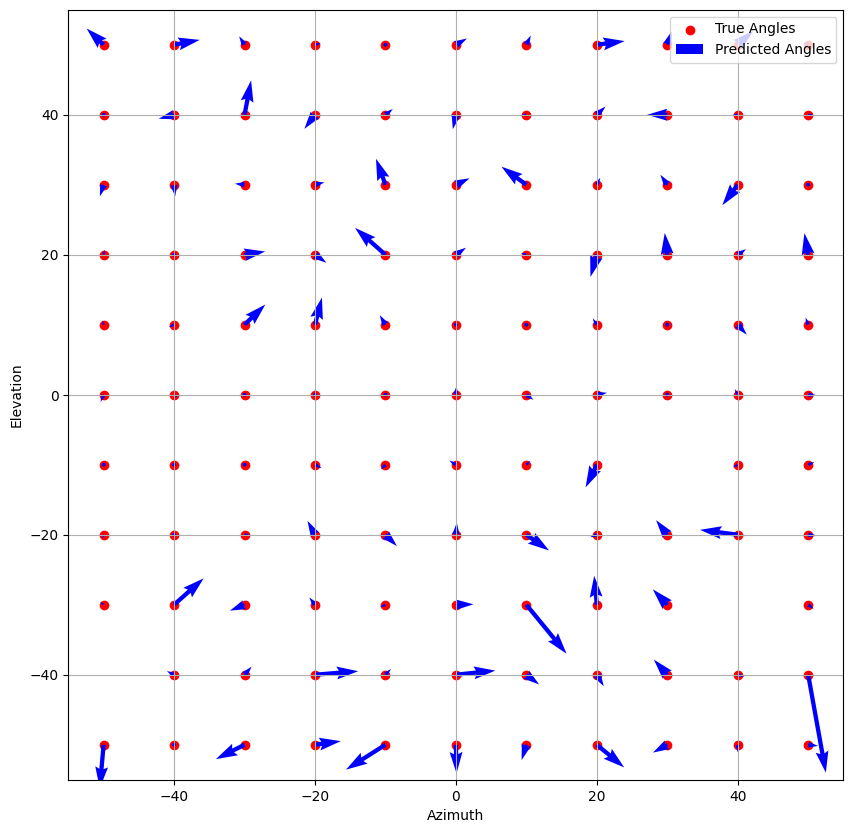

In [24]:
criterion = nn.MSELoss()
experiment_path = '/home/mohammad.hallaq/workarea/AoA-Pruning/experiments'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pruned_model = pruned_model.to(device)
pruned_model.eval()

test_loss, num_samples = 0, 0
all_targets, all_outputs = np.zeros([1, 2]), np.zeros([1, 2])
with torch.no_grad():
    with tqdm(test_loader, desc='Testing', unit='batch') as pbar:
        for sample_inputs, targets in pbar:
            sample_inputs = sample_inputs.to(device)
            targets = targets.to(device)
            outputs = pruned_model(sample_inputs)
            loss = criterion(outputs, targets)
            num_samples += targets.shape[0]
            test_loss += loss.item()/num_samples
            all_targets = np.concatenate((all_targets, targets.cpu()))
            all_outputs = np.concatenate((all_outputs, outputs.cpu()))
            pbar.set_postfix({'Val Loss': test_loss})
    all_outputs = all_outputs[1:]
    all_targets = all_targets[1:]
    test_loss = test_loss / len(val_loader)
    print(f"Test Set Loss = {test_loss}")
    quiver_path = os.path.join(experiment_path, "testing_quiver_plot.png")
    plot_quiver(all_targets, all_outputs, quiver_path)

In [9]:
def analyze_model_and_save_to_csv(model, val_loader, device=None, iterations=1, csv_file='model_analysis.csv', model_name=None):
  
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    first_batch = next(iter(val_loader))
    input_tensor, true_angles = first_batch
    input_tensor = input_tensor.to(device)


    model.to(device)
    example_inputs = input_tensor.to(device)
    print('This is the shape of the input: ', example_inputs.shape)
    

    analysis_results = {
        'model_name': model_name if model_name else model.__class__.__name__,
        'model_size_mb (MB)': None,
        'GFLOPs (GFLOPs)': None,
        'Total_Params (count)': None,
        'First_Forward_Pass_Time (s)': None,
        'Training_Time (s)': None,
        'Inference_Time (s)': None,
        'CUDA_Time (ms)': None,
        'CPU_Time (ms)': None,
        'mse': None,
        'mae': None
    }
    
 
    try:
        model.to(device)
        example_inputs = example_inputs.to(device)
    
 
        flops, params = tp.utils.count_ops_and_params(model, example_inputs)
        analysis_results['GFLOPs (GFLOPs)'] = flops  
        analysis_results['Total_Params (count)'] = params

    except Exception:
        pass 


    try:
        torch.save(model.state_dict(), "temp.pth")
        model_size = os.path.getsize("temp.pth") / (1024 * 1024)  # Convert to MB
        os.remove("temp.pth")
        analysis_results['model_size_mb (MB)'] = model_size
    except Exception:
        pass


    try:
        model.eval()
        with torch.no_grad():
            start_time = time.time()
            _ = model(example_inputs)
            end_time = time.time()
        analysis_results['First_Forward_Pass_Time (s)'] = end_time - start_time
    except Exception:
        pass

    try:
        iterations = 1000 # Number of iterations within each test
        num_tests = 20 # Number of times to run the inference test
        all_times = [] # To store the inference times of each test

        for test in range(num_tests):
            start_time = time.time()
            for _ in range(iterations):
                with torch.no_grad():
                    _ = model(example_inputs)
            end_time = time.time()
            inference_time = (end_time - start_time) / iterations
            all_times.append(inference_time)
        
        average_inference_time = sum(all_times) / num_tests
        
        analysis_results['Inference_Time (s)'] = average_inference_time
    except Exception:
        pass


    try:
        model.eval()
        with torch.no_grad():
            if torch.cuda.is_available():
                torch.cuda.synchronize()  
                with profile(use_cuda=True) as prof:
                    _ = model(example_inputs)
                # Collect CUDA times
                cuda_time_total = sum(evt.cuda_time for evt in prof.key_averages())
                cpu_time_total = sum(evt.cpu_time_total for evt in prof.key_averages())
                analysis_results['CUDA_Time (ms)'] = cuda_time_total / 1e3
                analysis_results['CPU_Time (ms)'] = cpu_time_total / 1e3
            else:
                with profile(use_cuda=False) as prof:
                    _ = model(example_inputs)
                # Collect CPU times only
                cpu_time_total = sum(evt.cpu_time_total for evt in prof.key_averages())
                analysis_results['CPU_Time (ms)'] = cpu_time_total / 1e3
    except Exception as e:
        print(f"Error during profiling: {e}")
        pass

    try:
        model.eval()
        y_preds = []
        y_true = []
        with torch.inference_mode():
            for sample in val_loader:
                data, target = sample[0].to(device), sample[1].to(device)
                y_true += target.tolist()
                output = model(data)
                y_preds += output.cpu().tolist()

        y_true = np.array(y_true)
        y_preds = np.array(y_preds)


        mse = np.square(y_true - y_preds).mean()
        mae = np.absolute(y_true - y_preds).mean()

        analysis_results['mse'] = mse
        analysis_results['mae'] = mae
    except Exception:
        pass
    

    file_exists = os.path.isfile(csv_file)
    
    with open(csv_file, mode='a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=analysis_results.keys())
        
        if not file_exists:
            writer.writeheader()  
        
        writer.writerow(analysis_results)  

    return analysis_results

In [12]:
# Set seed for reproducibility
torch.manual_seed(42)

# Free up cached memory
torch.cuda.empty_cache()

# Clear all the gradients
torch.cuda.reset_max_memory_allocated()

example_inputs = torch.randn(128, 1, 8, 4096)  

results = analyze_model_and_save_to_csv(original_model, val_loader, device=None, iterations=1, csv_file='model_analysis.csv')


This is the shape of the input:  torch.Size([128, 8, 4096])


STAGE:2024-09-27 07:00:56 1531592:1531592 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-09-27 07:00:56 1531592:1531592 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-09-27 07:00:56 1531592:1531592 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [11]:
results

{'model_name': 'MobileNetV3',
 'model_size_mb (MB)': 2.1971359252929688,
 'GFLOPs (GFLOPs)': 23439648.0,
 'Total_Params (count)': 548482,
 'First_Forward_Pass_Time (s)': 0.0075342655181884766,
 'Training_Time (s)': None,
 'Inference_Time (s)': 0.01575898751020432,
 'CUDA_Time (ms)': 3.2840884089211326,
 'CPU_Time (ms)': 47.796,
 'mse': 1.2235874766855361,
 'mae': 0.576736716231774}

In [13]:
results

{'model_name': 'MobileNetV3',
 'model_size_mb (MB)': 2.1971359252929688,
 'GFLOPs (GFLOPs)': 23439648.0,
 'Total_Params (count)': 548482,
 'First_Forward_Pass_Time (s)': 0.010128259658813477,
 'Training_Time (s)': None,
 'Inference_Time (s)': 0.018788700044155122,
 'CUDA_Time (ms)': 3.9351331035248798,
 'CPU_Time (ms)': 53.335,
 'mse': 1.2235874766855361,
 'mae': 0.576736716231774}

In [20]:
# Define input shape
input_size = (1, 8, 4096)  # For MNIST-like input

# Capture summary into a string and write to file
with open("model_structure.txt", "w") as f:
    summary_string = summary(pruned_model, input_size=input_size, verbose=0)
    f.write(str(summary_string))

In [30]:
def calculate_average_deviation(loader, model):
    device = next(model.parameters()).device
    model.to(device)
    total_azimuth_deviation = 0
    total_elevation_deviation = 0
    num_samples = 0
    with torch.no_grad():
        for batch in loader:
            inputs, true_angles = batch
            inputs, true_angles = inputs.to(device), true_angles.to(device)
            predicted = model(inputs).cpu().numpy()
            true_angles = true_angles.cpu().numpy()
            azimuth_deviation = np.abs(predicted[:, 0] - true_angles[:, 0])
            elevation_deviation = np.abs(predicted[:, 1] - true_angles[:, 1])
        
            total_azimuth_deviation += np.sum(azimuth_deviation)
            total_elevation_deviation += np.sum(elevation_deviation)
            num_samples += len(true_angles)
    avg_azimuth_deviation = total_azimuth_deviation / num_samples
    avg_elevation_deviation = total_elevation_deviation / num_samples
    return avg_azimuth_deviation, avg_elevation_deviation

In [31]:
avg_azim_dev, avg_elev_dev = calculate_average_deviation(val_loader, pruned_model)
print(avg_azim_dev, avg_elev_dev)

2.0799208594635883 2.202856791666683
